In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import psutil
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau

#enabling GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# reduced the batch size from 32 to 16 ---> trained for 35 epochs --->

In [ ]:
#data augmentation with normalisation
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:

data_dir = "C:/Users/bhuva/Desktop/FINAL/NEW_70_20_10"  #directory path
batch_size = 16 
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#resnet50 with pretrained images weights from imagenet1k
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 100)  #100 classes/ species trained
model = model.to(device)

In [ ]:
# 5. Hyperparameters \

num_epochs = 35
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping_patience = 20

c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_log = []
best_val_loss = np.inf
patience_counter = 0

In [ ]:
# 7. Training loop with 
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start_time = time.time()
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = 0.0, 0.0

    # Validation
    model.eval()
    
    all_preds = []
    with torch.no_grad():
        correct, total = 0, 0
        val_running_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            '''probs = torch.softmax(outputs, dim=1)  # Get probabilities
            all_probs.append(probs.cpu().numpy())'''
            
        val_loss = val_running_loss / total
        val_acc = correct / total
    #all_probs = np.vstack(all_probs)

    scheduler.step(val_loss)

    # Document metrics
    epoch_time = time.time() - epoch_start_time
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # Memory in MB
    train_log.append({
        'epoch': epoch + 1, 'train_loss': train_loss, 'train_acc': train_acc, 
        'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time, 'memory_usage_mb': mem_usage
    })

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_fix_final.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

# Save logs to CSV
pd.DataFrame(train_log).to_csv("training_log_fix_final.csv", index=False)

Epoch 1/35: 100%|██████████| 256/256 [01:52<00:00,  2.27batch/s]


Epoch 1/35 - Train Loss: 3.5074, Train Acc: 0.2074, Val Loss: 1.8545, Val Acc: 0.4837, Time: 121.19s


Epoch 2/35: 100%|██████████| 256/256 [01:51<00:00,  2.30batch/s]


Epoch 2/35 - Train Loss: 2.2240, Train Acc: 0.4439, Val Loss: 1.3450, Val Acc: 0.6270, Time: 119.66s


Epoch 3/35: 100%|██████████| 256/256 [01:51<00:00,  2.30batch/s]


Epoch 3/35 - Train Loss: 1.7724, Train Acc: 0.5412, Val Loss: 1.0873, Val Acc: 0.6900, Time: 119.31s


Epoch 4/35: 100%|██████████| 256/256 [01:50<00:00,  2.31batch/s]


Epoch 4/35 - Train Loss: 1.5561, Train Acc: 0.5844, Val Loss: 0.9358, Val Acc: 0.7214, Time: 118.83s


Epoch 5/35: 100%|██████████| 256/256 [01:50<00:00,  2.32batch/s]


Epoch 5/35 - Train Loss: 1.4138, Train Acc: 0.6252, Val Loss: 0.9332, Val Acc: 0.7179, Time: 118.72s


Epoch 6/35: 100%|██████████| 256/256 [01:51<00:00,  2.31batch/s]


Epoch 6/35 - Train Loss: 1.3297, Train Acc: 0.6404, Val Loss: 0.8544, Val Acc: 0.7319, Time: 119.22s


Epoch 7/35: 100%|██████████| 256/256 [01:50<00:00,  2.31batch/s]


Epoch 7/35 - Train Loss: 1.2410, Train Acc: 0.6589, Val Loss: 0.8438, Val Acc: 0.7366, Time: 118.67s


Epoch 8/35: 100%|██████████| 256/256 [01:50<00:00,  2.31batch/s]


Epoch 8/35 - Train Loss: 1.1657, Train Acc: 0.6917, Val Loss: 0.7882, Val Acc: 0.7646, Time: 118.80s


Epoch 9/35: 100%|██████████| 256/256 [01:50<00:00,  2.32batch/s]


Epoch 9/35 - Train Loss: 1.1085, Train Acc: 0.6939, Val Loss: 0.8130, Val Acc: 0.7541, Time: 118.45s


Epoch 10/35: 100%|██████████| 256/256 [01:49<00:00,  2.33batch/s]


Epoch 10/35 - Train Loss: 1.0670, Train Acc: 0.7007, Val Loss: 0.7721, Val Acc: 0.7751, Time: 119.55s


Epoch 11/35: 100%|██████████| 256/256 [01:51<00:00,  2.31batch/s]


Epoch 11/35 - Train Loss: 1.0023, Train Acc: 0.7273, Val Loss: 0.6768, Val Acc: 0.7855, Time: 119.57s


Epoch 12/35: 100%|██████████| 256/256 [01:50<00:00,  2.32batch/s]


Epoch 12/35 - Train Loss: 0.9625, Train Acc: 0.7325, Val Loss: 0.6919, Val Acc: 0.7867, Time: 118.30s


Epoch 13/35: 100%|██████████| 256/256 [01:50<00:00,  2.32batch/s]


Epoch 13/35 - Train Loss: 0.9344, Train Acc: 0.7532, Val Loss: 0.6901, Val Acc: 0.8019, Time: 118.17s


Epoch 14/35: 100%|██████████| 256/256 [01:50<00:00,  2.31batch/s]


Epoch 14/35 - Train Loss: 0.9192, Train Acc: 0.7481, Val Loss: 0.6684, Val Acc: 0.8030, Time: 118.54s


Epoch 15/35: 100%|██████████| 256/256 [01:49<00:00,  2.34batch/s]


Epoch 15/35 - Train Loss: 0.8485, Train Acc: 0.7711, Val Loss: 0.6763, Val Acc: 0.8042, Time: 117.24s


Epoch 16/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 16/35 - Train Loss: 0.8547, Train Acc: 0.7608, Val Loss: 0.6882, Val Acc: 0.7867, Time: 116.45s


Epoch 17/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 17/35 - Train Loss: 0.8334, Train Acc: 0.7711, Val Loss: 0.6654, Val Acc: 0.8007, Time: 116.90s


Epoch 18/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 18/35 - Train Loss: 0.8331, Train Acc: 0.7794, Val Loss: 0.7605, Val Acc: 0.7879, Time: 117.00s


Epoch 19/35: 100%|██████████| 256/256 [01:48<00:00,  2.35batch/s]


Epoch 19/35 - Train Loss: 0.7682, Train Acc: 0.7921, Val Loss: 0.6747, Val Acc: 0.8042, Time: 116.84s


Epoch 20/35: 100%|██████████| 256/256 [01:48<00:00,  2.35batch/s]


Epoch 20/35 - Train Loss: 0.7401, Train Acc: 0.7940, Val Loss: 0.7353, Val Acc: 0.8030, Time: 116.75s


Epoch 21/35: 100%|██████████| 256/256 [01:48<00:00,  2.35batch/s]


Epoch 21/35 - Train Loss: 0.7725, Train Acc: 0.7892, Val Loss: 0.7518, Val Acc: 0.7762, Time: 116.93s


Epoch 22/35: 100%|██████████| 256/256 [01:49<00:00,  2.33batch/s]


Epoch 22/35 - Train Loss: 0.7736, Train Acc: 0.7874, Val Loss: 0.7402, Val Acc: 0.7914, Time: 117.90s


Epoch 23/35: 100%|██████████| 256/256 [01:50<00:00,  2.33batch/s]


Epoch 23/35 - Train Loss: 0.7534, Train Acc: 0.7923, Val Loss: 0.7116, Val Acc: 0.8007, Time: 118.05s


Epoch 24/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 24/35 - Train Loss: 0.6457, Train Acc: 0.8280, Val Loss: 0.5986, Val Acc: 0.8193, Time: 116.95s


Epoch 25/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 25/35 - Train Loss: 0.5477, Train Acc: 0.8541, Val Loss: 0.6147, Val Acc: 0.8217, Time: 116.36s


Epoch 26/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 26/35 - Train Loss: 0.5412, Train Acc: 0.8610, Val Loss: 0.5896, Val Acc: 0.8310, Time: 116.21s


Epoch 27/35: 100%|██████████| 256/256 [01:48<00:00,  2.35batch/s]


Epoch 27/35 - Train Loss: 0.5016, Train Acc: 0.8671, Val Loss: 0.5939, Val Acc: 0.8427, Time: 116.70s


Epoch 28/35: 100%|██████████| 256/256 [01:48<00:00,  2.37batch/s]


Epoch 28/35 - Train Loss: 0.5282, Train Acc: 0.8595, Val Loss: 0.6289, Val Acc: 0.8333, Time: 116.02s


Epoch 29/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 29/35 - Train Loss: 0.5187, Train Acc: 0.8581, Val Loss: 0.6348, Val Acc: 0.8333, Time: 116.37s


Epoch 30/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 30/35 - Train Loss: 0.5015, Train Acc: 0.8673, Val Loss: 0.6643, Val Acc: 0.8310, Time: 116.34s


Epoch 31/35: 100%|██████████| 256/256 [01:48<00:00,  2.36batch/s]


Epoch 31/35 - Train Loss: 0.4827, Train Acc: 0.8744, Val Loss: 0.6300, Val Acc: 0.8287, Time: 116.28s


Epoch 32/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 32/35 - Train Loss: 0.4896, Train Acc: 0.8764, Val Loss: 0.6094, Val Acc: 0.8333, Time: 116.86s


Epoch 33/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 33/35 - Train Loss: 0.4467, Train Acc: 0.8808, Val Loss: 0.5975, Val Acc: 0.8368, Time: 116.88s


Epoch 34/35: 100%|██████████| 256/256 [01:53<00:00,  2.27batch/s]


Epoch 34/35 - Train Loss: 0.4309, Train Acc: 0.8881, Val Loss: 0.6246, Val Acc: 0.8427, Time: 122.03s


Epoch 35/35: 100%|██████████| 256/256 [01:49<00:00,  2.35batch/s]


Epoch 35/35 - Train Loss: 0.4193, Train Acc: 0.8915, Val Loss: 0.5984, Val Acc: 0.8403, Time: 116.87s


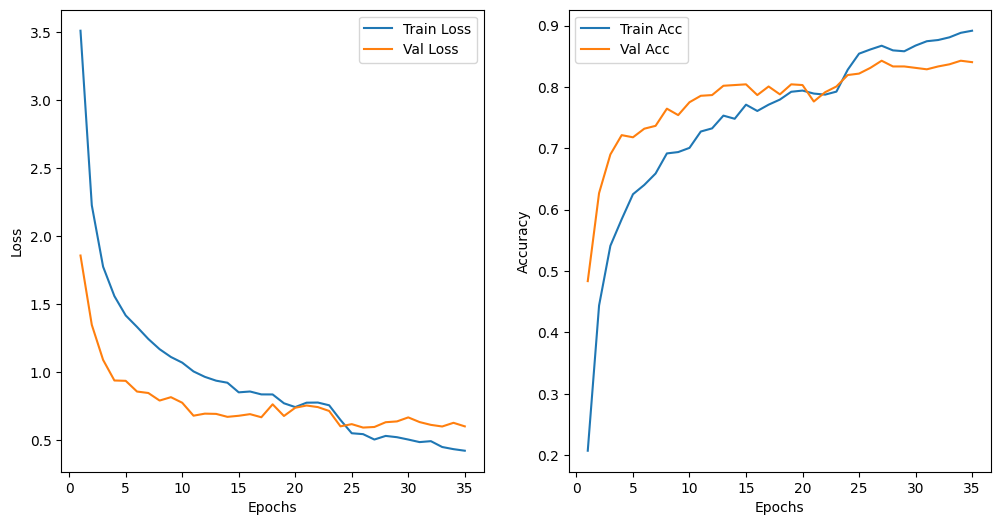

In [9]:
# 8. Plot training history
history_df = pd.DataFrame(train_log)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 9. Evaluate on Test Set
model.load_state_dict(torch.load('best_model_fix_final.pth'))
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())



C:\Users\bhuva\AppData\Local\Temp\ipykernel_32896\7812595.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_fix.pth'))


'# Confusion Matrix\nconf_mat = confusion_matrix(all_labels, all_preds)\nplt.figure(figsize=(10, 8))\nsns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix\')\nplt.show()'

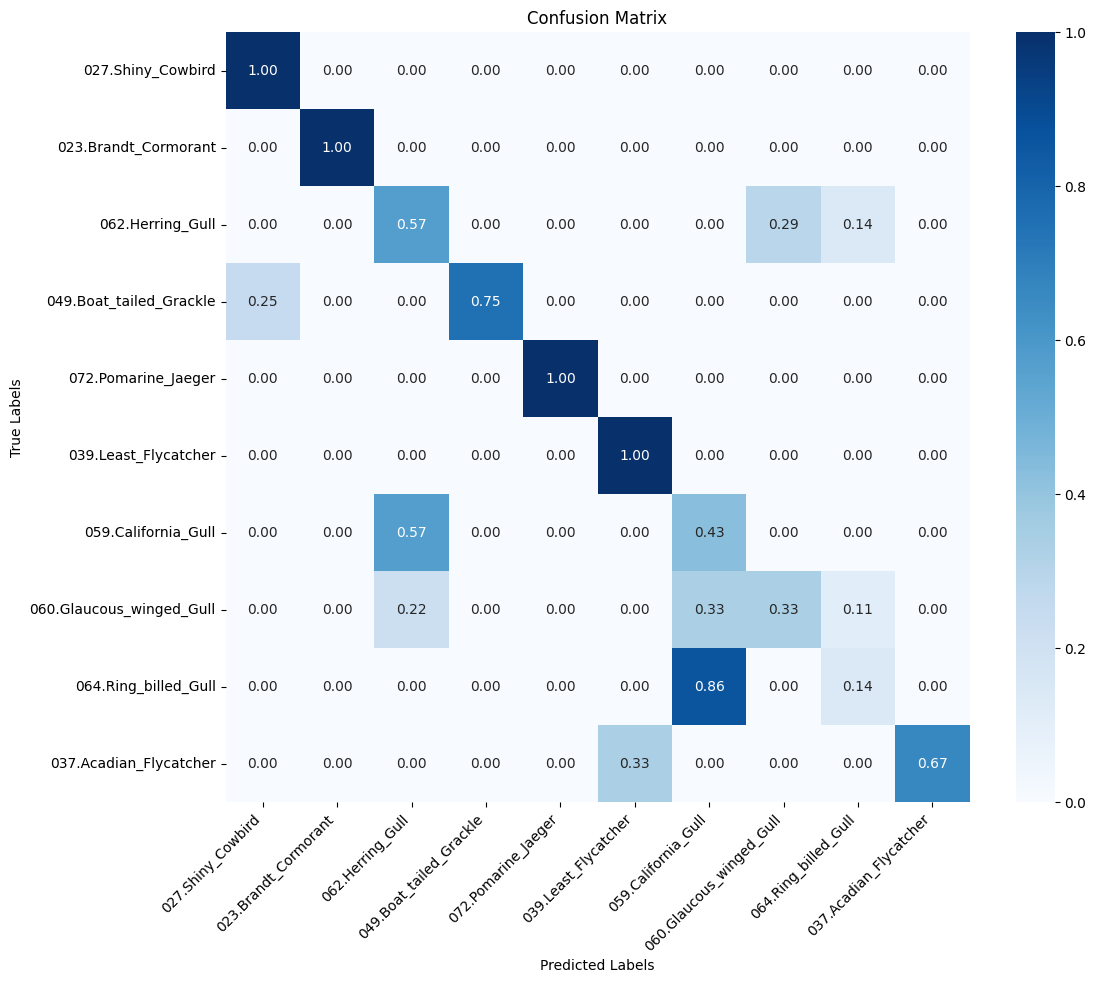

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, top_n=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if top_n:
        misclassified_counts = np.sum(cm, axis=1) - np.diag(cm)
        top_confused_indices = np.argsort(misclassified_counts)[-top_n:]
        cm = cm[top_confused_indices, :][:, top_confused_indices]
        classes = [classes[i] for i in top_confused_indices]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

class_names = ["001.Black_footed_Albatross", "002.Laysan_Albatross", "003.Sooty_Albatross", "004.Groove_billed_Ani", "005.Crested_Auklet", "006.Least_Auklet", "007.Parakeet_Auklet", "008.Rhinoceros_Auklet", "009.Brewer_Blackbird", "010.Red_winged_Blackbird", "011.Rusty_Blackbird", "012.Yellow_headed_Blackbird", "013.Bobolink", "014.Indigo_Bunting", "015.Lazuli_Bunting", "016.Painted_Bunting", "017.Cardinal", "018.Spotted_Catbird", "019.Gray_Catbird", "020.Yellow_breasted_Chat", "021.Eastern_Towhee", "022.Chuck_will_Widow", "023.Brandt_Cormorant", "024.Red_faced_Cormorant", "025.Pelagic_Cormorant", "026.Bronzed_Cowbird", "027.Shiny_Cowbird", "028.Brown_Creeper", "029.American_Crow", "030.Fish_Crow", "031.Black_billed_Cuckoo", "032.Mangrove_Cuckoo", "033.Yellow_billed_Cuckoo", "034.Gray_crowned_Rosy_Finch", "035.Purple_Finch", "036.Northern_Flicker", "037.Acadian_Flycatcher", "038.Great_Crested_Flycatcher", "039.Least_Flycatcher", "040.Olive_sided_Flycatcher", "041.Scissor_tailed_Flycatcher", "042.Vermilion_Flycatcher", "043.Yellow_bellied_Flycatcher", "044.Frigatebird", "045.Northern_Fulmar", "046.Gadwall", "047.American_Goldfinch", "048.European_Goldfinch", "049.Boat_tailed_Grackle", "050.Eared_Grebe", "051.Horned_Grebe", "052.Pied_billed_Grebe", "053.Western_Grebe", "054.Blue_Grosbeak", "055.Evening_Grosbeak", "056.Pine_Grosbeak", "057.Rose_breasted_Grosbeak", "058.Pigeon_Guillemot", "059.California_Gull", "060.Glaucous_winged_Gull", "061.Heermann_Gull", "062.Herring_Gull", "063.Ivory_Gull", "064.Ring_billed_Gull", "065.Slaty_backed_Gull", "066.Western_Gull", "067.Anna_Hummingbird", "068.Ruby_throated_Hummingbird", "069.Rufous_Hummingbird", "070.Green_Violetear", "071.Long_tailed_Jaeger", "072.Pomarine_Jaeger", "073.Blue_Jay", "074.Florida_Jay", "075.Green_Jay", "076.Dark_eyed_Junco", "077.Tropical_Kingbird", "078.Gray_Kingbird", "079.Belted_Kingfisher", "080.Green_Kingfisher", "081.Pied_Kingfisher", "082.Ringed_Kingfisher", "083.White_breasted_Kingfisher", "084.Red_legged_Kittiwake", "085.Horned_Lark", "086.Pacific_Loon", "087.Mallard", "088.Western_Meadowlark", "089.Hooded_Merganser", "090.Red_breasted_Merganser", "091.Mockingbird", "092.Nighthawk", "093.Clark_Nutcracker", "094.White_breasted_Nuthatch", "095.Baltimore_Oriole", "096.Hooded_Oriole", "097.Orchard_Oriole", "098.Scott_Oriole", "099.Ovenbird", "100.Brown_Pelican",]


plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True, top_n=10)

In [ ]:
import torch
import torchvision.models as models

num_classes = 100  
model = models.resnet50(pretrained=True)  
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  

# Load the saved weights
model.load_state_dict(torch.load('best_model_fix_final.pth', map_location=torch.device('cpu')))
model.eval()  

# Function to calculate test accuracy
def test_accuracy(model, test_loader, device):
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)  # Count total number of images
            correct += (predicted == labels).sum().item()  

    accuracy = 100 * correct / total
    return accuracy

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


accuracy = test_accuracy(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')


c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\bhuva\AppData\Local\Temp\ipykernel_32896\2017011990.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick

Test Accuracy: 81.16%
